In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import mpl
import numpy as np
import datetime 
import warnings
import tensorflow
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题



## 1.数据初步分析

采用selenium工具爬取2023年西安市咸阳国际机场航班信息，以下是数据的预览

In [4]:
# 读取数据
df = pd.read_csv("./csv/西安航班.csv",engine='python')

# 修改列名
df.columns = ['航班号', '出发地', '到达地', '机型', '计划起飞时间', '计划到达时间',
              '实际起飞时间', '实际到达时间', '进出港类型', '是否为节假日']

df.head()

,航班号,出发地,到达地,机型,计划起飞时间,计划到达时间,实际起飞时间,实际到达时间,进出港类型,是否为节假日
0,HV2380,XIA,KUL,A330,2023/1/1 0:30,2023/1/1 5:40,2023/1/1 0:39,2023/1/1 5:59,出港,1
1,IU6364,XIA,DMK,B737,2023/1/1 1:35,2023/1/1 5:30,2023/1/1 1:40,2023/1/1 5:17,出港,1
2,IU5438,XIA,HKT,B737,2023/1/1 1:35,2023/1/1 6:35,2023/1/1 3:18,2023/1/1 7:51,出港,1
3,YL3490,XIA,LXA,A319,2023/1/1 6:00,2023/1/1 9:35,2023/1/1 6:14,2023/1/1 9:27,出港,1
4,VQ9682,XIA,KHN,A319,2023/1/1 6:10,2023/1/1 7:50,2023/1/1 6:18,2023/1/1 7:52,出港,1


表格中并未标注是否延误的信息，需要根据计划起飞时间和实际起飞时间自行计算。
	
因为只是要做出港延误率的预测，所以这里初步决定只分析**离港飞机**的数据。暂且忽略进港飞机的数据，忽略掉这部分数据之后，数据集体积将缩小一半。
	
在这些数据中，有2个字段是无用字段。即：出发地，进出港类型。对于这两个字段，每一行的取值都是相等的，所以应该直接忽略掉。


考虑到**时间特征**对延误可能会具有一定的影响，所以从计划起飞时间中抽离出5个时间特征

In [5]:
# 清理缺失值，清理入港信息
df = df.dropna()
df = df[df["进出港类型"]=='出港']


def cal_length(takeoff, arrive):
    takeoff = datetime.datetime.strptime(str(takeoff), '%Y/%m/%d %H:%M')
    arrive = datetime.datetime.strptime(str(arrive), '%Y/%m/%d %H:%M')
    len = (arrive-takeoff).seconds / 60 /60
    len = int(len)
    return len

def cal_departure_delay(planned_takeoff, actual_takeoff):
    if pd.isnull(actual_takeoff):  # 如果实际起飞时间为缺失值，则返回缺失值
        return None
    planned_takeoff = datetime.datetime.strptime(str(planned_takeoff), '%Y/%m/%d %H:%M')
    actual_takeoff = datetime.datetime.strptime(str(actual_takeoff), '%Y/%m/%d %H:%M')
    delay = (actual_takeoff - planned_takeoff).seconds / 60  # 计算延误时间（分钟为单位）
    return delay

df['起飞延迟时间'] = df.apply(lambda row: cal_departure_delay(row["计划起飞时间"], row["实际起飞时间"]), axis=1)  # 添加起飞延迟时间列

df['旅程时长'] = df.apply(lambda row: cal_length(row["计划起飞时间"],row["计划到达时间"]), axis=1)  # 增加旅程时长字段
df = df.drop(columns=[ '实际到达时间','进出港类型','出发地'])     # 清除明显无用的几列信息
df['航空公司'] = df['航班号'].apply(lambda x: x[:2])              # 增加航空公司字段

holiday_flights_count = df[df['是否为节假日'] == 1].shape[0]
non_holiday_flights_count = df[df['是否为节假日'] == 0].shape[0]


In [6]:
df['几月'] = df['计划起飞时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M').month)
df['几号'] = df['计划起飞时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M').day)
df['第几周'] = df['计划起飞时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M').isocalendar()[1])
df['星期几'] = df['计划起飞时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M').isoweekday())
df['出发时间段'] = df['计划起飞时间'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M').hour)
df.head()

,航班号,到达地,机型,计划起飞时间,计划到达时间,实际起飞时间,是否为节假日,起飞延迟时间,旅程时长,航空公司,几月,几号,第几周,星期几,出发时间段
0,HV2380,KUL,A330,2023/1/1 0:30,2023/1/1 5:40,2023/1/1 0:39,1,9.0,5,HV,1,1,52,7,0
1,IU6364,DMK,B737,2023/1/1 1:35,2023/1/1 5:30,2023/1/1 1:40,1,5.0,3,IU,1,1,52,7,1
2,IU5438,HKT,B737,2023/1/1 1:35,2023/1/1 6:35,2023/1/1 3:18,1,103.0,5,IU,1,1,52,7,1
3,YL3490,LXA,A319,2023/1/1 6:00,2023/1/1 9:35,2023/1/1 6:14,1,14.0,3,YL,1,1,52,7,6
4,VQ9682,KHN,A319,2023/1/1 6:10,2023/1/1 7:50,2023/1/1 6:18,1,8.0,1,VQ,1,1,52,7,6



另外，天气原因也是影响航班延误的重要因素，所以从网上下载了一份西安市2022年一月到六月的天气表格，将其载入程序中

In [7]:
weather = pd.read_csv("./csv/西安天气.csv",engine='python')# 读取天气表

weather.columns = ['日期','最高温', '最低温', '天气', '风向', '风力']
weather.head()

,日期,最高温,最低温,天气,风向,风力
0,2023/1/1,9,-1,多云,东北风,1级
1,2023/1/2,3,-1,小雨,东南风,1级
2,2023/1/3,2,-2,大雪,西北风,1级
3,2023/1/4,-2,-6,小雪,东风,1级
4,2023/1/5,-3,-4,多云,东北风,1级



把下载过来的天气表格和原有的起飞信息表格合并在一起以作为接下来所使用的数据集


In [8]:
df["日期"] = df["计划起飞时间"].apply(lambda x: str(x).split(" ")[0])    # 两表合并
df = pd.merge(df, weather, on='日期')
df.head()

,航班号,到达地,机型,计划起飞时间,计划到达时间,实际起飞时间,是否为节假日,起飞延迟时间,旅程时长,航空公司,...,几号,第几周,星期几,出发时间段,日期,最高温,最低温,天气,风向,风力
0,HV2380,KUL,A330,2023/1/1 0:30,2023/1/1 5:40,2023/1/1 0:39,1,9.0,5,HV,...,1,52,7,0,2023/1/1,9,-1,多云,东北风,1级
1,IU6364,DMK,B737,2023/1/1 1:35,2023/1/1 5:30,2023/1/1 1:40,1,5.0,3,IU,...,1,52,7,1,2023/1/1,9,-1,多云,东北风,1级
2,IU5438,HKT,B737,2023/1/1 1:35,2023/1/1 6:35,2023/1/1 3:18,1,103.0,5,IU,...,1,52,7,1,2023/1/1,9,-1,多云,东北风,1级
3,YL3490,LXA,A319,2023/1/1 6:00,2023/1/1 9:35,2023/1/1 6:14,1,14.0,3,YL,...,1,52,7,6,2023/1/1,9,-1,多云,东北风,1级
4,VQ9682,KHN,A319,2023/1/1 6:10,2023/1/1 7:50,2023/1/1 6:18,1,8.0,1,VQ,...,1,52,7,6,2023/1/1,9,-1,多云,东北风,1级





根据计划起飞时间和实际起飞时间计算延误信息，将延误信息追加到最后一列，这一列就作为数据集的标签。至此，本算法使用的数据集已经准备完毕。


In [9]:
def cal_late(jh, sj):
    jh = datetime.datetime.strptime(str(jh), '%Y/%m/%d %H:%M')      # 计算是否延误
    sj = datetime.datetime.strptime(str(sj), '%Y/%m/%d %H:%M')
    if sj < jh :
        return 0      # 提前起飞
    elif (sj-jh).seconds / 60 < 15:
        return 0   # 准点起飞
    else:
        return 1
    
df['延误'] = df.apply(lambda row: cal_late(row["计划起飞时间"],row["实际起飞时间"]), axis=1)
df = df.drop(columns=[ '实际起飞时间'])
df.head()

,航班号,到达地,机型,计划起飞时间,计划到达时间,是否为节假日,起飞延迟时间,旅程时长,航空公司,几月,...,第几周,星期几,出发时间段,日期,最高温,最低温,天气,风向,风力,延误
0,HV2380,KUL,A330,2023/1/1 0:30,2023/1/1 5:40,1,9.0,5,HV,1,...,52,7,0,2023/1/1,9,-1,多云,东北风,1级,0
1,IU6364,DMK,B737,2023/1/1 1:35,2023/1/1 5:30,1,5.0,3,IU,1,...,52,7,1,2023/1/1,9,-1,多云,东北风,1级,0
2,IU5438,HKT,B737,2023/1/1 1:35,2023/1/1 6:35,1,103.0,5,IU,1,...,52,7,1,2023/1/1,9,-1,多云,东北风,1级,1
3,YL3490,LXA,A319,2023/1/1 6:00,2023/1/1 9:35,1,14.0,3,YL,1,...,52,7,6,2023/1/1,9,-1,多云,东北风,1级,0
4,VQ9682,KHN,A319,2023/1/1 6:10,2023/1/1 7:50,1,8.0,1,VQ,1,...,52,7,6,2023/1/1,9,-1,多云,东北风,1级,0


---

## 2.数据初步可视化

对于特征的可视化，主要是基于主要使用工具包matplotlib、seaborn、pandas来进行整理和绘制。



###  2.1 航空公司和延误情况的关系

根据现实生活的经验，确实存在一部分航空公司经常延误，而一些航空公司通常都是准点，可以明确地观察到不同航空公司的延误之间存在明显的差异。这表明航空公司是影响航班延误的一个重要因素，因此需要将航空公司作为选择特征的一项考虑因素。

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gb_hkgs = df.groupby('航空公司')['延误'].mean()

print("0-0.2 延误率范围的航空公司:")
for airline in gb_hkgs[gb_hkgs.between(0, 0.2)].index:
    print(airline)

print("\n0.2-0.4 延误率范围的航空公司:")
for airline in gb_hkgs[gb_hkgs.between(0.2, 0.4)].index:
    print(airline)

print("\n0.4-0.6 延误率范围的航空公司:")
for airline in gb_hkgs[gb_hkgs.between(0.4, 0.6)].index:
    print(airline)

print("\n0.6-0.8 延误率范围的航空公司:")
for airline in gb_hkgs[gb_hkgs.between(0.6, 0.8)].index:
    print(airline)

print("\n0.8-1.0 延误率范围的航空公司:")
for airline in gb_hkgs[gb_hkgs.between(0.8, 1.0)].index:
    print(airline)

categories = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
airlines = [
    ["EG", "HJ", "IR"],
    ["AS", "BT", "CU", "IW", "JE", "JI", "KW", "LJ", "TP", "UH", "UP", "VP", "WJ", "WQ", "XK", "XS", "YL", "ZU"],
    ["DV", "FH", "FX", "GY", "HZ", "JH", "JS", "JX", "MA", "NB", "NL", "SO", "SY", "TO", "TZ", "UQ", "VI", "VQ", "WR", "XR", "ZM"],
    ["DM", "HF", "HT", "HV", "IG", "IU", "LX", "RN", "YT"],
    ["C3", "EW", "GI", "ID", "IG", "IH", "JV", "KI"]
]




0-0.2 延误率范围的航空公司:
EG
HJ
IR

0.2-0.4 延误率范围的航空公司:
AS
BT
CU
IW
JE
JI
KW
LJ
TP
UH
UP
VP
WJ
WQ
XK
XS
YL
ZU

0.4-0.6 延误率范围的航空公司:
DV
FH
FX
GY
HZ
JH
JS
JX
MA
NB
NL
SO
SY
TO
TZ
UQ
VI
VQ
WR
XR
ZM

0.6-0.8 延误率范围的航空公司:
DM
HF
HT
HV
IG
IU
LX
RN
YT

0.8-1.0 延误率范围的航空公司:
C3
EW
GI
ID
IG
IH
JV
KI


### 2.2到达地和延误情况的关系

由于不同路线的拥挤程度和空中管制情况有所差异，因此图 3 中显示的信息完全符合假设，因此可以推测到达地也是影响延误的重要因素，因此到达地也是需要选择的特征之一。


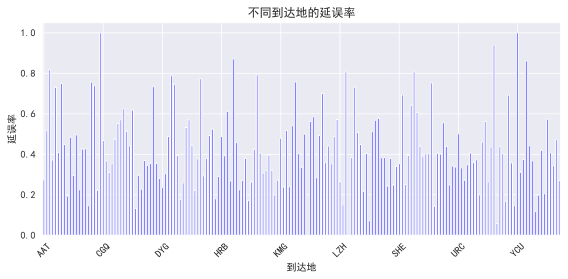

In [11]:
from matplotlib import pyplot as plt

# 创建画布，并指定大小
plt.figure(figsize=(8, 4))

# 按到达地分组，计算延误率
gb_dest = df.groupby('到达地')['延误'].mean()

# 绘制柱状图
gb_dest.plot(kind='bar', color='blue')

# 添加标签和标题
plt.xlabel("到达地")
plt.ylabel("延误率")
plt.title("不同到达地的延误率")

# 调整坐标轴刻度
plt.xticks(rotation=45)

# 设置要显示的刻度
x_ticks = [0, 20, 40, 60, 80,100,120,140,160]  # 指定要显示的刻度的下标位置
x_tick_labels = [gb_dest.index[i] for i in x_ticks]  # 根据下标获取刻度标签
plt.xticks(x_ticks, x_tick_labels)  # 设置刻度

# 将 x 坐标轴上的点柱状设为红色
for x_tick_line in plt.gca().get_xticklines():
    x_tick_line.set_color('red')

# 展示图表
plt.tight_layout()
plt.show()


对于到达地与航班延误的关系，为了获得更准确的预测结果，本项目希望尽可能利用更多可用的特征，使模型预测的准确率越高的原则，另提出了一个构想，是否存在航班途径的路线距离越远，航班的延误率越高的关系。在下图中，通过用旅行时长刻画航班路线跨过的距离，能够了解旅行时长无法作为合适的选择特征之一。

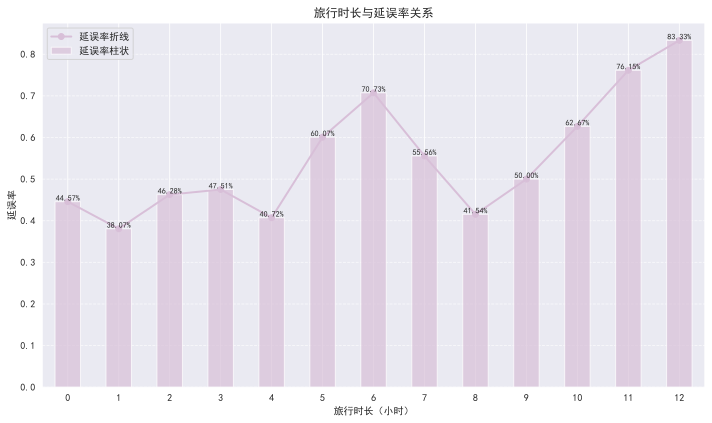

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置全局中文字体为SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

gb_lcsc = df.groupby('旅程时长')['延误'].mean()

plt.figure(figsize=(10, 6))  # 调整图表尺寸

# 绘制折线图
gb_lcsc.plot(color='thistle', marker='o', linewidth=2, label='延误率折线')

# 绘制条形图
gb_lcsc.plot(color='thistle', kind='bar', alpha=0.7, label='延误率柱状')

plt.title('旅行时长与延误率关系')  # 添加标题
plt.xlabel('旅行时长（小时）')  # 添加横坐标标签
plt.ylabel('延误率')  # 添加纵坐标标签

plt.xticks(rotation=0)  # 调整横轴标签角度

# 添加数据标签
for x, y in enumerate(gb_lcsc):
    plt.text(x, y, '{:.2f}%'.format(y*100), ha='center', va='bottom', fontsize=8)

plt.legend()  # 添加图例
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加网格线

plt.tight_layout()  # 调整布局
plt.show()


### 2.3飞机型号和延误情况的关系

前期猜测飞机型号可能也会影响航班延误率，因此对飞机型号与航班延误率也做一个可视化展示。

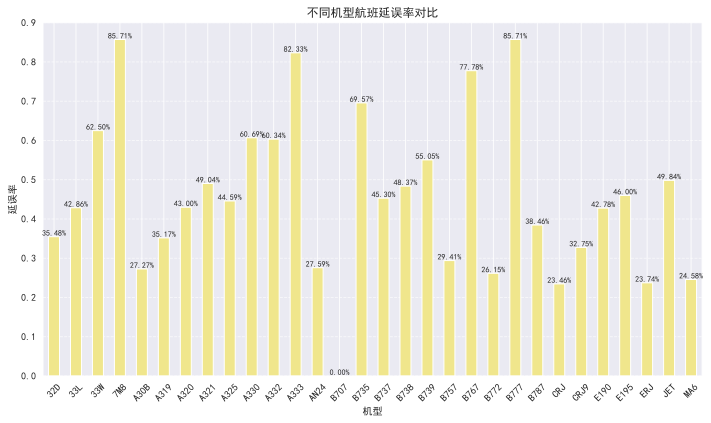

In [13]:
import matplotlib.pyplot as plt

# 设置全局中文字体为SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))  # 调整图表尺寸

gb_mode = df.groupby('机型')['延误'].mean()
gb_mode.plot(color='khaki', kind='bar')

plt.title('不同机型航班延误率对比')  # 添加标题
plt.xlabel('机型')  # 添加横坐标标签
plt.ylabel('延误率')  # 添加纵坐标标签

plt.xticks(rotation=45)  # 调整横轴标签角度

# 添加数据标签
for x, y in enumerate(gb_mode):
    plt.text(x, y, '{:.2f}%'.format(y*100), ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加网格线

plt.tight_layout()  # 调整布局
plt.show()


### 2.4 出发时段对延误的影响

推测白天、凌晨的航班延误率会有一定影响。从图 6 中可以明显看出，出发时间对于航班延误率具有具有比较明显影响，因此我们选用出发时间作为航班延误率作为特征之一。

<Figure size 640x480 with 0 Axes>

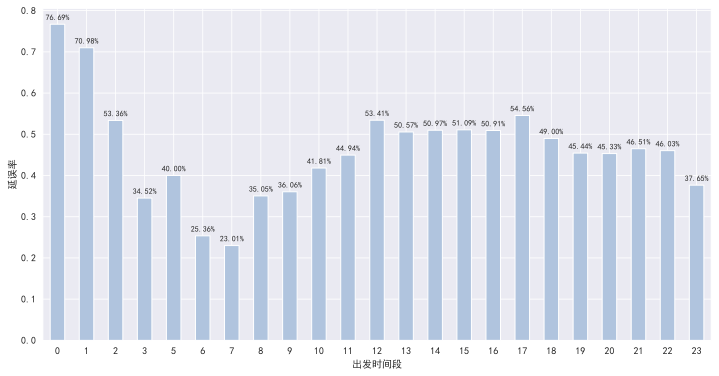

In [14]:
import matplotlib.pyplot as plt

plt.figure()

plt.figure(figsize=(12, 6))  # 调整图表尺寸
df_t1 = df.groupby('出发时间段')['延误'].mean()
df_t1.plot(color='lightsteelblue', kind='bar')

plt.xlabel("出发时间段")
plt.ylabel("延误率")

# 调整X轴标签的角度，以免重叠
plt.xticks(rotation=0)

# 添加数据标签
for i, v in enumerate(df_t1.values):
    plt.text(i, v + 0.01, '{:.2%}'.format(v), ha='center', fontsize=8)

plt.show()
plt.close()


### 2.5其他时间特征对延误的影响

首先通过从计划出发的时间分离出四个特征：月份、日期、周数、星期进行可视化展示。

从图中可知，1 月份至 2 月份航班延误率最高，由于冬天雨雪天气较多引导致概率较大；其次月初与月末的航班延误率也较高，每月中旬的延误率较低，由于机场的航空调度与社会活动有关导致概率较大，由此可知日期对于航班延误率有一定影响，也作为选用的特征之一；周数与月份从图上可知无单独的影响，因此不选用这两个特征；从一周内来看，每周的中间阶段延误率是最高的，周末附近延误率低，可以暂时认为是一个有效的特征。


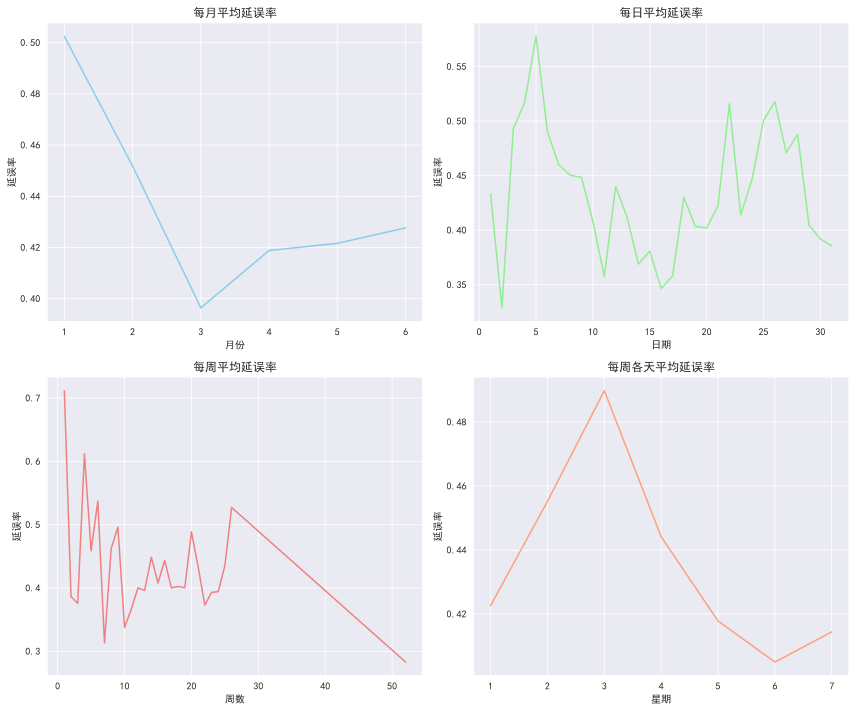

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 创建包含四个子图的大图

# 第一个子图
df_m = df.groupby('几月')['延误'].mean()
df_m.plot(color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title('每月平均延误率')
axs[0, 0].set_xlabel('月份')
axs[0, 0].set_ylabel('延误率')

# 第二个子图
df_d = df.groupby('几号')['延误'].mean()
df_d.plot(color='lightgreen', ax=axs[0, 1])
axs[0, 1].set_title('每日平均延误率')
axs[0, 1].set_xlabel('日期')
axs[0, 1].set_ylabel('延误率')

# 第三个子图
df_w = df.groupby('第几周')['延误'].mean()
df_w.plot(color='lightcoral', ax=axs[1, 0])
axs[1, 0].set_title('每周平均延误率')
axs[1, 0].set_xlabel('周数')
axs[1, 0].set_ylabel('延误率')

# 第四个子图
df_wd = df.groupby('星期几')['延误'].mean()
df_wd.plot(color='lightsalmon', ax=axs[1, 1])
axs[1, 1].set_title('每周各天平均延误率')
axs[1, 1].set_xlabel('星期')
axs[1, 1].set_ylabel('延误率')

# 调整子图之间的间距
plt.tight_layout()

plt.show()


### 2.6天气对延误的影响

在下雪天气中，观察数据飞机延误的概率均达到 80%以上，由此可知天气对于航班延误率有比较大的影响，并且在其它天气下的延误率均保持在 40%左右，因此将此特征作为本项目选定的特征之一

但与天气有关的数据还存在风力、风向，由下图可观察到风力风向与航班延误率的关系基本可以忽略


Text(0, 0.5, '延误率')

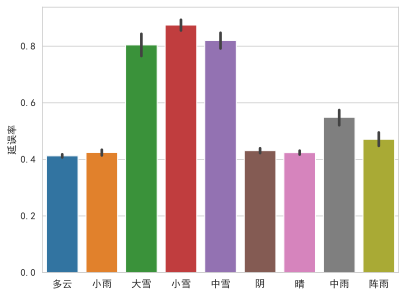

In [16]:
plt.figure()
sns.set_style('whitegrid', {'font.sans-serif':['simhei','Arial']})
sns.barplot(x="天气", y="延误", data=df)
plt.xlabel(" ")
plt.ylabel("延误率")

<Axes: xlabel='最低温'>

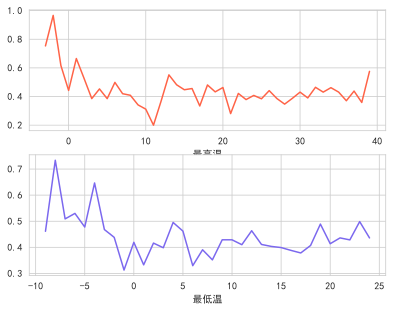

In [17]:
# 展示温度
plt.figure()
df_m = df.groupby('最高温')['延误'].mean()
plt.subplot(211)
df_m.plot(color='tomato')

df_d = df.groupby('最低温')['延误'].mean()
plt.subplot(212)
df_d.plot(color='mediumslateblue')

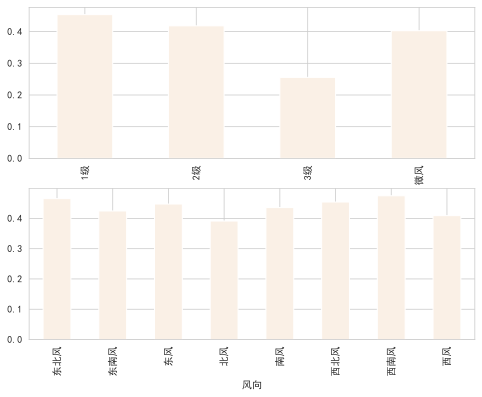

In [18]:
# 展示风力
plt.figure(figsize=(8,6))
df_m = df.groupby('风力')['延误'].mean()
plt.subplot(211)
df_m.plot(color='linen',kind='bar')

df_d = df.groupby('风向')['延误'].mean()
plt.subplot(212)
df_d.plot(color='linen', kind='bar')

plt.show()
plt.close()


风和温度的指标，在这个问题上没有什么用处，直接把他们去掉


In [19]:
df = df.drop(columns=['最高温', '最低温','风力','风向',])

### 2.7 节假日和航班延误的关系

通过计算节假日航班数量占总航班数量的比例、节假日与非节假日的平均延误时长、延误航班处于节假日的比例等数据可以发现，节假日对于航班延误的影响不大

In [20]:
print("节假日航班数量：", holiday_flights_count)
print("非节假日航班数量：", non_holiday_flights_count)
print("节假日航班数量占总航班数量：", holiday_flights_count/non_holiday_flights_count)

delayed_flights_count = df[df['起飞延迟时间'] > 15].shape[0]
print("延迟时间超过15分钟的航班数量：", delayed_flights_count)

holiday_avg_delay = df[df['是否为节假日'] == 1]['起飞延迟时间'].mean()
non_holiday_avg_delay = df[df['是否为节假日'] == 0]['起飞延迟时间'].mean()

print("节假日平均起飞延迟时间：", holiday_avg_delay)
print("非节假日平均起飞延迟时间：", non_holiday_avg_delay)
delayed_flights = df[df['起飞延迟时间'] > 15]  # 选择起飞延迟超过15分钟的航班
holiday_delayed_flights = delayed_flights[delayed_flights['是否为节假日'] == 1]  # 在延迟航班中选择节假日航班

proportion_holiday_delayed = len(holiday_delayed_flights) / len(delayed_flights)  # 计算节假日延迟航班所占比例
print("延迟时间超过15分钟的航班中，节假日航班所占比例：", proportion_holiday_delayed)

节假日航班数量： 9205
非节假日航班数量： 69516
节假日航班数量占总航班数量： 0.13241555900799815
延迟时间超过15分钟的航班数量： 39099
节假日平均起飞延迟时间： 155.85996740901683
非节假日平均起飞延迟时间： 150.0956182749295
延迟时间超过15分钟的航班中，节假日航班所占比例： 0.12143533082687537


###  2.8 标签数值化
将三个预计需要用得到的字符型特征转换成字符型特征

把转换后的特征加一个后缀名添加到表格中，给表格增添新的三列：航空公司_num，到达地_num，天气_num

In [21]:
from sklearn import preprocessing

le_hkgs = preprocessing.LabelEncoder()    # 航空公司
le_hkgs.fit(np.array(df['航空公司']))

le_dest = preprocessing.LabelEncoder()   # 到达地
le_dest.fit(np.array(df['到达地']))

le_weat = preprocessing.LabelEncoder()    # 天气
le_weat.fit(np.array(df['天气']))

le_model = preprocessing.LabelEncoder()    # 飞机型号
le_model.fit(np.array(df['机型']))

df['航空公司_num'] = df['航空公司'].apply(lambda x: int(le_hkgs.transform([x])[0]))
df['到达地_num'] = df['到达地'].apply(lambda x: int(le_dest.transform([x])[0]))
df['天气_num'] = df['天气'].apply(lambda x: int(le_weat.transform([x])[0]))
df['机型_num'] = df['机型'].apply(lambda x: int(le_model.transform([x])[0]))

##  3.特征选择与特征工程

In [22]:
print(df.columns)
columnss=[ '是否为节假日', '航空公司_num', '到达地_num','天气_num','机型_num','旅程时长','几月',
       '几号', '第几周', '星期几', '出发时间段']

# 创建一个空的 DataFrame 来存储每个特征的得分
rank_df = pd.DataFrame(index=columnss, columns=['Pearson', 'Spearman', 'RandomForest', 'XGBoost','RSR','Average'])
df.to_csv('output.csv', index=False)  # 'output.csv' 是输出文件的名称，index=False 表示不输出行索引


Index(['航班号', '到达地', '机型', '计划起飞时间', '计划到达时间', '是否为节假日', '起飞延迟时间', '旅程时长',
       '航空公司', '几月', '几号', '第几周', '星期几', '出发时间段', '日期', '天气', '延误', '航空公司_num',
       '到达地_num', '天气_num', '机型_num'],
      dtype='object')


###    3.1基于相关系数的特征选择
使用相关系数法判断各个特征与延误率的关系并输出为表格

In [23]:
from scipy.stats import pearsonr, spearmanr

pear=[]
spear=[]
for name in columnss:
    x=df[name]
    y=df['延误']
    pear.append(pearsonr(x, y))
    spear.append(spearmanr(x, y))
    _,pearvalue = pearsonr(x,y)
    _,spearvalue = spearmanr(x,y)
    value = (pearvalue+spearvalue)/2
    print(name+'综合得分:'+str(value)+',斯皮尔曼系数：'+str(spearvalue)+',皮尔逊系数：'+str(pearvalue))
    rank_df.loc[name,'Pearson'] = abs(pearvalue)
    rank_df.loc[name,'Spearman'] = abs(spearvalue)

for name in columnss:
    x=df[name]
    y=df['延误']
    pear.append(pearsonr(x, y))
    spear.append(spearmanr(x, y))
    _,pearvalue = pearsonr(x,y)
    _,spearvalue = spearmanr(x,y)
    value = (pearvalue+spearvalue)/2
    
        
#print(value)

是否为节假日综合得分:0.0026650728703742086,斯皮尔曼系数：0.00266507287037449,皮尔逊系数：0.002665072870373927
航空公司_num综合得分:0.09211868468712216,斯皮尔曼系数：0.1842373693555772,皮尔逊系数：1.8667123213853532e-11
到达地_num综合得分:0.5899806108105623,斯皮尔曼系数：0.21909009126048698,皮尔逊系数：0.9608711303606376
天气_num综合得分:0.5823978637115013,斯皮尔曼系数：0.3707499482885315,皮尔逊系数：0.7940457791344709
机型_num综合得分:2.980531774759579e-08,斯皮尔曼系数：5.961056474034544e-08,皮尔逊系数：7.075484614691364e-14
旅程时长综合得分:9.751408508646983e-106,斯皮尔曼系数：3.5197879029108785e-111,皮尔逊系数：1.9502781819414938e-105
几月综合得分:1.20510322506386e-31,斯皮尔曼系数：2.2469297619003197e-31,皮尔逊系数：1.6327668822740026e-32
几号综合得分:0.20732193039404545,斯皮尔曼系数：0.22054693808781442,皮尔逊系数：0.19409692270027645
第几周综合得分:2.3699869449357942e-39,斯皮尔曼系数：4.739930553865172e-39,皮尔逊系数：4.333600641647651e-44
星期几综合得分:2.5457965729709767e-15,斯皮尔曼系数：2.45278060952863e-15,皮尔逊系数：2.638812536413324e-15
出发时间段综合得分:2.0834290425826028e-181,斯皮尔曼系数：1.1897996072123535e-218,皮尔逊系数：4.1668580851652056e-181


###   3.2 基于嵌入法特征选择

####   （1）使用随机森林进行特征选择

In [24]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X=df[columnss]
Y=df['延误']

# 创建随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 拟合随机森林模型
rf_classifier.fit(X, Y)

# 获取特征重要性
feature_importance = rf_classifier.feature_importances_

# 将特征重要性与特征名对应起来
feature_importance_df = pd.DataFrame({'Feature': columnss, 'Importance': feature_importance})

# 按照重要性降序排列
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 将随机森林和XGBoost模型的特征重要性存储到rank_df中
rank_df['RandomForest'] = feature_importance_df.set_index('Feature').loc[columnss].sort_index()['Importance']

# 打印特征重要性
print("特征重要性：")
print(feature_importance_df)


特征重要性：
     Feature  Importance
2    到达地_num    0.179110
10     出发时间段    0.164441
7         几号    0.136314
1   航空公司_num    0.111117
8        第几周    0.097254
9        星期几    0.088115
4     机型_num    0.073807
3     天气_num    0.057826
5       旅程时长    0.041510
6         几月    0.040980
0     是否为节假日    0.009525


#### （2）使用XGBoost进行特征选择

In [25]:
import xgboost as xgb
import pandas as pd

# 假设df是包含数据的DataFrame，columnss是特征列的列表
X = df[columnss]
Y = df['延误']

# 创建XGBoost分类器模型
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# 拟合XGBoost模型
xgb_classifier.fit(X, Y)

# 获取特征重要性
feature_importance = xgb_classifier.feature_importances_

# 将特征重要性与特征名对应起来
feature_importance_df = pd.DataFrame({'Feature': columnss, 'Importance': feature_importance})

# 按照重要性降序排列
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 将随机森林和XGBoost模型的特征重要性存储到rank_df中
rank_df['XGBoost'] = feature_importance_df.set_index('Feature').loc[columnss].sort_index()['Importance']

# 打印特征重要性
print("特征重要性：")
print(feature_importance_df)


特征重要性：
     Feature  Importance
10     出发时间段    0.146771
2    到达地_num    0.117543
5       旅程时长    0.116365
8        第几周    0.115664
1   航空公司_num    0.087746
3     天气_num    0.086694
4     机型_num    0.079488
6         几月    0.077910
7         几号    0.075963
9        星期几    0.054466
0     是否为节假日    0.041390


###   3.3 使用秩和比综合评价法进行特征选择

In [26]:
import pandas as pd
import numpy as np

def calculate_feature_score(feature, target):
    # 假设使用特征的均值和标准差作为得分计算的依据
    feature_mean = feature.mean()
    feature_std = feature.std()
    
    # 这里假设计算方法是 (均值 - 最小值) / 标准差，你可以根据实际情况修改这个公式
    feature_score = (feature_mean - feature.min()) / feature_std
    
    return feature_score

# 假设df是包含数据的DataFrame，columnss是特征列的列表
X = df[columnss]
Y = df['延误']

# 创建一个空的DataFrame来存储每个特征的得分
rank = pd.DataFrame(index=columnss, columns=['Score'])

# 计算每个特征的得分
for feature in columnss:
    # 假设calculate_feature_score 是对特征 feature 的秩和比综合评价得分的计算函数
    # 这里仅是示例，你需要根据具体的秩和比综合评价方法来编写这个函数
    feature_score = calculate_feature_score(X[feature], Y)
    rank.loc[feature, 'Score'] = feature_score
    
    
# 按得分降序排列
rank = rank.sort_values(by='Score', ascending=False)
rank_df['RSR'] = rank

# 打印特征得分
print("特征得分：")
print(rank)



特征得分：
             Score
航空公司_num  3.416753
出发时间段     2.607955
到达地_num   2.009769
天气_num    1.917373
旅程时长      1.828081
机型_num    1.725677
几号        1.672766
第几周       1.618072
几月        1.500761
星期几       1.498457
是否为节假日    0.363887


### 3.4 计算综合得分

In [27]:
from sklearn.preprocessing import StandardScaler

# 对数据进行标准化处理
scaler = StandardScaler()
scaled_rank_df = scaler.fit_transform(rank_df)
scaled_rank_df = pd.DataFrame(scaled_rank_df, columns=rank_df.columns)

# 添加索引
scaled_rank_df.index = rank_df.index

# 计算综合得分并求平均值
scaled_rank_df['Average'] = scaled_rank_df.mean(axis=1)

# 保留与columnss列表中相同的行
scaled_rank_df = scaled_rank_df.loc[columnss]

# 按得分降序排列
scaled_rank_df = scaled_rank_df.sort_values(by='Average', ascending=False)

scaled_rank_df.head(12)


,Pearson,Spearman,RandomForest,XGBoost,RSR,Average
到达地_num,2.328564,1.010637,1.728315,0.910062,0.247939,1.245103
天气_num,1.832725,2.204098,-0.648273,-0.144025,0.118571,0.672619
出发时间段,-0.527345,-0.713454,1.440876,1.908757,1.085477,0.638862
航空公司_num,-0.527345,0.736370,0.395983,-0.108070,2.217900,0.542967
几号,0.049551,1.022102,0.889716,-0.510704,-0.223909,0.245351
第几周,-0.527345,-0.713454,0.124334,0.845853,-0.300488,-0.114220
旅程时长,-0.527345,-0.713454,-0.967980,0.869815,-0.006449,-0.269083
机型_num,-0.527345,-0.713454,-0.335120,-0.390254,-0.149827,-0.423200
星期几,-0.527345,-0.713454,-0.054743,-1.245224,-0.467965,-0.601746
几月,-0.527345,-0.713454,-0.978367,-0.444178,-0.464739,-0.625617



## 4. 模型应用
最终确定的拟合性能比较好的有效特征是[航空公司，到达地，出发时间段，几号，天气，第几周]

In [28]:
X = df[['航空公司_num','到达地_num','出发时间段','天气_num','几号','第几周']]
y = df[['延误']]

X = np.array(X)  
y = np.array(y)


df.head()

,航班号,到达地,机型,计划起飞时间,计划到达时间,是否为节假日,起飞延迟时间,旅程时长,航空公司,几月,...,第几周,星期几,出发时间段,日期,天气,延误,航空公司_num,到达地_num,天气_num,机型_num
0,HV2380,KUL,A330,2023/1/1 0:30,2023/1/1 5:40,1,9.0,5,HV,1,...,52,7,0,2023/1/1,多云,0,15,85,2,9
1,IU6364,DMK,B737,2023/1/1 1:35,2023/1/1 5:30,1,5.0,3,IU,1,...,52,7,1,2023/1/1,多云,0,21,34,2,15
2,IU5438,HKT,B737,2023/1/1 1:35,2023/1/1 6:35,1,103.0,5,IU,1,...,52,7,1,2023/1/1,多云,1,21,57,2,15
3,YL3490,LXA,A319,2023/1/1 6:00,2023/1/1 9:35,1,14.0,3,YL,1,...,52,7,6,2023/1/1,多云,0,54,97,2,5
4,VQ9682,KHN,A319,2023/1/1 6:10,2023/1/1 7:50,1,8.0,1,VQ,1,...,52,7,6,2023/1/1,多云,0,47,77,2,5


### 4.1 总体建模
为了提高预测的正确率，不使用传统的单模型预测方法，而是使用四种模型进行组合预测.

本模型使用了3个子模型组成，运算过程为：对任意一组数据，分别送入lightGBM和CatBoost模型中，两个模型分别给出一个延误的概率值，下面一层的神经网络再根据这三个概率值进行加权组合得出最终的概率，把概率值进行四舍五入即可得到分类。

对于训练集，首先，将训练集拆分一次，85%的数据留下来供lightGBM和CatBoost使用。15%的数据留到最后用来进行总结果的验证

对于这85%的数据，再进行一次拆分。

对于原始的约八万条数据而言，72%用于lightGBM、CatBoost模型基模型的训练，13%用于这两个基模型的验证，15%用于组合模型的验证。

In [29]:
from sklearn.model_selection import train_test_split

X, X_test_nn, y, y_test_nn = train_test_split(X, y, test_size=0.15,random_state=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=15)# random_state=0

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

df_preds = pd.DataFrame()

### 4.2 基分类器：CatBoost分类器

经过对数据集的多次训练验证寻到了一组比较合理的参数，这里直接使用调好的参数

In [30]:
import catboost as cb  # catboost分类器
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model_cat = cb.CatBoostClassifier(iterations=600, 
                            depth=7, 
                            learning_rate=0.1, 
                            logging_level='Silent',
                            random_state=18
                             )

model_cat.fit(X_train, y_train)

preds_class = model_cat.predict(X_test)
result = [round(x) for x in preds_class]

accuracy = accuracy_score(y_test, result)
recall = recall_score(y_test, result)
f1 = f1_score(y_test, result)
auc = roc_auc_score(y_test, result)

print('正确率：%.2f%%' % (accuracy * 100))
print('召回率：%.2f%%' % (recall * 100))
print('F1值：%.2f%%' % (f1 * 100))
print('AUC：%.2f%%' % (auc * 100))

# 将测试集1的概率计算出来存入预测表格中
df_preds['cat'] = model_cat.predict_proba(X_test)[:,1]

正确率：71.11%
召回率：58.01%
F1值：63.88%
AUC：69.71%


### 4.3 基分类器：lightGBM分类器

同样，经过对数据集的多次训练验证寻到了一组比较合理的参数，这里直接使用调好的参数

In [31]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 270,
    'max_depth': 7,
    'num_leaves': 20,
    'min_child_samples': 10,
    'reg_alpha': 0.8,
    'reg_lambda': 0.2,
    'min_child_weight': 7,
    'colsample_bytree': 0.7,
    'subsample': 0.6,
    'learning_rate': 0.71
}

# 训练模型
model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=2000,
                      valid_sets=lgb_eval,
                     )

# 预测数据集
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
result = [round(x) for x in y_pred]

accuracy = accuracy_score(y_test, result)
recall = recall_score(y_test, result)
f1 = f1_score(y_test, result)
auc = roc_auc_score(y_test, result)

print('正确率：%.2f%%' % (accuracy * 100))
print('召回率：%.2f%%' % (recall * 100))
print('F1值：%.2f%%' % (f1 * 100))
print('AUC：%.2f%%' % (auc * 100))

df_preds['lgb'] = y_pred
df_preds.head(10)


[LightGBM] [Info] Number of positive: 24694, number of negative: 32181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 56875, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434180 -> initscore=-0.264816
[LightGBM] [Info] Start training from score -0.264816
正确率：70.70%
召回率：60.79%
F1值：64.63%
AUC：69.64%


,cat,lgb
0,0.408529,0.511487
1,0.188334,0.110991
2,0.169258,0.095818
3,0.187534,0.191366
4,0.382792,0.561062
5,0.278233,0.224909
6,0.614061,0.621158
7,0.389394,0.238866
8,0.649249,0.622019
9,0.644621,0.733557


### 4.5 构造神经网络的训练数据

从上面的输出结果可以看出，2个基分类器各自分类的结果平均下来在70%左右

我们将两个分类器对同一组数据的预测结果和真实的标签值整合到一起之后，就得到了下面这个表格

表格第一列和第二列分别是两个分类器预测出来的概率值，这两列将作为神经网络的输入值

第三列是这组数据真正的标签值，在训练神经网络的过程中，这组数据作为标签值

In [32]:
df_preds['real'] = np.array(y_test);df_preds.head()

,cat,lgb,real
0,0.408529,0.511487,1
1,0.188334,0.110991,1
2,0.169258,0.095818,0
3,0.187534,0.191366,0
4,0.382792,0.561062,0


### 4.6 使用神经网络寻找权重
传统的权重寻找算法依靠手工计算规律并预估效果，由人力去寻找权重并不是个适宜的方案，所以这里并未直接使用“结果=变量1权重1+变量2权重2”这个公式，而是直接使用神经网络进行权重分配。

In [33]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
numpy.random.seed(70)

X_train_nn = df_preds[['cat','lgb']]
y_train_nn = df_preds[['real']]

# 搭建神经层
model_nn = Sequential()

layer1 = Dense(20, input_dim=2, activation='relu', name='layer1')
model_nn.add(layer1)

layer2 = Dense(1, activation='sigmoid')
model_nn.add(layer2)

# 编译模型
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 训练模型
model_nn.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=1000, batch_size=2000, verbose=1)


Epoch 1/1000
5/5 [==============================] - 3s 70ms/step - loss: 0.7019 - accuracy: 0.5632 - val_loss: 0.7025 - val_accuracy: 0.5453
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6998 - accuracy: 0.5632 - val_loss: 0.7006 - val_accuracy: 0.5453
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6979 - accuracy: 0.5632 - val_loss: 0.6987 - val_accuracy: 0.5453
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6960 - accuracy: 0.5632 - val_loss: 0.6967 - val_accuracy: 0.5453
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.5632 - val_loss: 0.6946 - val_accuracy: 0.5453
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6921 - accuracy: 0.5632 - val_loss: 0.6924 - val_accuracy: 0.5453
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6900 - accuracy: 0.5632 - val_loss: 0.6902 - val_accuracy: 0.5453
Epoch 8/1000


### 4.7 验证完整模型效果
将神经网络训练好之后，使用测试集2进行整个模型的预测（三个基模型+神经网络）

测试权重分配是否对预测性能有所提升

这里的X_test_nn是测试集2的特征集

y_test_nn是测试集2的标签集

In [34]:
temp_pred_cat = model_cat.predict(X_test_nn)
temp_pred_lgb = model_lgb.predict(X_test_nn)

df_preds2 = pd.DataFrame()
df_preds2['cat'] = temp_pred_cat
df_preds2['lgb'] = temp_pred_lgb

df_preds2['real'] = y_test_nn

df_preds2.head()

,cat,lgb,real
0,1,0.622136,0
1,0,0.323495,0
2,0,0.586364,1
3,0,0.299822,1
4,1,0.381187,1


X_test_nn这个特征集经过三个集模型的处理之后，得到两个概率序列，将两个概率序列和真实的标签值组合在一起，得到一个表格。

把这个表格的xgb、rf、lgb三个字段输入神经网络中，得到神经网络输出的最终概率序列。

把这个序列也添加到表格中

In [35]:
# 使用神经网络进行权重分配，获取最终分类结果
nn_pred = model_nn.predict(df_preds2[['cat','lgb']])
df_preds2['组合结果'] = nn_pred
df_preds2['class'] = df_preds2['组合结果'].apply(lambda x: int(round(x)))
df_preds2.head()

370/370 [==============================] - 1s 2ms/step


,cat,lgb,real,组合结果,class
0,1,0.622136,0,0.858888,1
1,0,0.323495,0,0.147247,0
2,0,0.586364,1,0.210415,0
3,0,0.299822,1,0.143706,0
4,1,0.381187,1,0.787217,1


In [36]:
acc = accuracy_score(df_preds2['class'],df_preds2['real'])
recall = recall_score(df_preds2['class'],df_preds2['real'])
f1 = f1_score(df_preds2['class'],df_preds2['real'])
auc = roc_auc_score(df_preds2['class'],df_preds2['real'])

print('组合预测的正确率为 %.2f%%' % (acc*100))
print('召回率：%.2f%%' % (recall * 100))
print('F1值：%.2f%%' % (f1 * 100))
print('AUC：%.2f%%' % (auc * 100))

组合预测的正确率为 71.37%
召回率：71.32%
F1值：63.99%
AUC：71.36%


‘**结论**

把组合的结果从概率转换成类别，根据标签计算组合的正确率。

发现正确率、召回率、F1分数值、AUC等指标**综合来看有较大进步，特别是召回率**

证实这个模型是有一定可行性的。